# Fake News Detection

## Pre-process Data

In [2]:
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')


def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences


def getEmbeddings(path,vector_dimension=300):
    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'] ,axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy = 88.54%


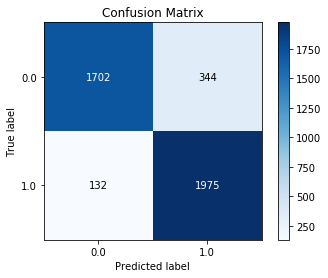

In [7]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings("train.csv")
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

clf = SVC()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 88.42%

plot_cmat(yte, y_pred)

## Naive-Bayes

Accuracy = 72.45%


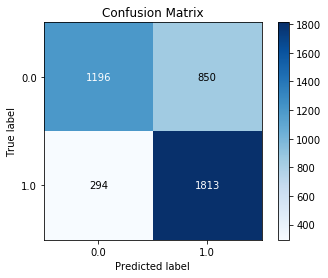

In [8]:
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%

plot_cmat(yte, y_pred)

## Support Vector Machine

Accuracy = 88.54%


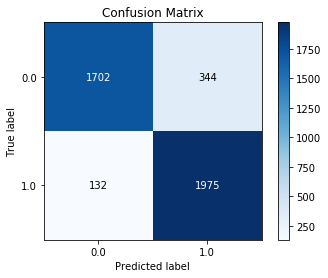

In [9]:
xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

clf = SVC()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 88.42%

plot_cmat(yte, y_pred)

## Neural Network using TensorFlow

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')


def baseline_model():
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configure the learning process of the model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


model = baseline_model()
model.summary()
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train, encoded_y, epochs=20, batch_size=64)
print("Model Trained!")
score = model.evaluate(x_test, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.69%

probabs = model.predict_proba(x_test)
y_pred = np.argmax(probabs, axis=1)
 

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 162       
Total params: 163,570
Trainable params: 163,570
Non-trainable params: 0
_________________________________________________________________
Epoc